In [1]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\shpar\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install -U pytorch_warmup

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\shpar\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
# Import necessary modules and libraries

import torch
import cv2
import numpy as np
import sys, os

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import pytorch_warmup as warmup
from skimage import io
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import pandas as pd


c:\Users\shpar\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Set the device
if torch.cuda.is_available():
  device = torch.device('cuda')

else:
  device = torch.device('cpu')

print(device)

cuda


# !! Custom dataset class defined

In [5]:
# Make a custom dataset to read csv file
class DiabetesDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.dataset_list = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    return len(self.dataset_list)
  def __getitem__(self, index):
    name_of_sample = "level" + str(self.dataset_list.iloc[index, 1])
    intermediate_path = os.path.join(self.root_dir, name_of_sample)
    image_path = os.path.join(intermediate_path, self.dataset_list.iloc[index, 0])
    image_path = image_path + ".jpeg"
    print(image_path)
    return_image = io.imread(image_path)

    y_label = torch.tensor(int(self.dataset_list.iloc[index, 1]))

    if self.transform != None:
      return_image = self.transform(return_image)

    return (return_image, y_label)

    

In [5]:
# load dataset
train_path = 'C:/Users/shpar/OneDrive/바탕 화면/ParkSangwoo_project/diabetes/TRAIN'
test_path = 'C:/Users/shpar/OneDrive/바탕 화면/ParkSangwoo_project/diabetes/TEST'

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((384, 384)),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                                     transforms.RandomHorizontalFlip(p = 0.3), 
                                     transforms.RandomVerticalFlip(p = 0.5)])


data_transform_test = transforms.Compose([transforms.ToTensor(),
                                          transforms.Resize((384, 384)),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#train = DiabetesDataset(csv_path, train_path, transform = data_transform)

train_dataset = datasets.ImageFolder(root=train_path, transform = data_transform)

train_dataloader = DataLoader(dataset=train_dataset, batch_size = 32, shuffle = True)

test_dataset = datasets.ImageFolder(root=test_path, 
                                    transform = data_transform_test)

test_dataloader = DataLoader(dataset=test_dataset, batch_size = 32, shuffle = False)

print("The length of our train_dataloader would be {:4d}".format(len(train_dataloader)))
print("The length of our test_dataloader would be {:4d}".format(len(test_dataloader)))

The length of our train_dataloader would be  799
The length of our test_dataloader would be  310


# Define Hyper Parameters

In [6]:
image_size = 384
patch_size = 16
embedded_dimension = 256
in_channels = 3
number_of_heads = 2
intermediate_nodes = 40
number_of_class = 5
encoder_blocks = 12

# training parameters
batch_size = 32
num_epochs = 100
initial_learning_rate = 1e-4

# Implementation of creating token for each diabetes data to be input into the encoder

In [ ]:
# First of all start with token's positional embedding
class TokenEmbed(nn.Module):
  """
  This code will try to generate the tokens of images as patches by using CNN to make some part of
  each image as token. The dimension of each input image will be in the form of (batch size, channels, width, height)
  After CNN has been used , it will result in (batch size, channels=embedded_dimension, w = width/patch_size, h = height/patch_size)
  Thus, there will be w ** 2 number of tokens ought to be used (we reshape them). 
  Also, since class token needs to be added, use cls_token to add 1 more token
  to each batch while independent positional encoding is added after embedding each token. 
  """
  def __init__(self, image_size = image_size, patch_size = patch_size, 
               in_channels = in_channels, embedded_dimension = embedded_dimension):
    super().__init__()
    self.image_size = image_size
    self.patch_size = patch_size
    self.n_patches = (image_size // patch_size) ** 2

    self.create_patches = nn.Conv2d(in_channels, embedded_dimension, 
                                  kernel_size = patch_size, stride = patch_size)
    
    """
    Have to understand the functionality of how this mechanism works
    """
    self.cls_token = nn.Parameter(torch.randn(1, 1, embedded_dimension))

    # Positional Encoding of each tokens (cos, sin)
    self.positions = nn.Parameter(torch.randn((self.n_patches + 1), embedded_dimension))
    
  def forward(self, inp):
    inp = self.create_patches(inp) # current shape: (batch size, embedded_dimension, num_batch_width, num_batch_height)

    inp = inp.reshape(inp.shape[0], inp.shape[1], -1)
    inp = inp.permute(0, 2, 1) # current shape: (batch size, embedded dimension, number of patches)

    number_of_batches = inp.shape[0]

    cls_token = repeat(self.cls_token, '() n e -> b n e', b = number_of_batches) # shape: (batch, 1, embedded_dimension)
    final_output = torch.cat([cls_token, inp], dim = 1)
    final_output = final_output + self.positions

    return final_output

# Check to see whether patch embedding was implemented properly

In [ ]:
# Check whether embedding proess is processed correctly
x = torch.randn(64, 3, 224, 224).to(device)
patch_embedding = TokenEmbed().to(device)
patch_output = patch_embedding(x)
print('(batch_size, number of patches, embedded size: ', patch_output.shape)

(batch_size, number of patches, embedded size:  torch.Size([64, 197, 256])


# Implementation of self- multi head attention

In [ ]:
# Multi-Head self attention
class MultiHeadAttention(nn.Module):
  """
  In this class, we are going to implement the attention functionality by dividing 
  our input data into each query, key, and value. The query is going to be the standard
  image token that we are going to compare,(comparing with keys) and put them into the
  softmax function along with scaling values to obtain energy value. Each energy value for all
  tokens in keys will be then be multiplied with values to obtain attention scores. Thus,
  allowing the model to learn the most related token regarding a certain query.
  """
  def __init__(self, embedded_size = embedded_dimension, number_of_heads = number_of_heads):
    super().__init__()
    self.embedded_size = embedded_size
    self.number_of_heads = number_of_heads
    self.query = nn.Linear(embedded_size, embedded_size)
    self.key = nn.Linear(embedded_size, embedded_size)
    self.value = nn.Linear(embedded_size, embedded_size)
    self.final_linear_layer = nn.Linear(embedded_size, embedded_size)

  def forward(self, x):
    query = self.query(x)
    query = query.reshape(query.shape[0], self.number_of_heads, query.shape[1], -1)
    
    key = self.key(x)
    key = key.reshape(key.shape[0], self.number_of_heads, key.shape[1], -1)


    value = self.value(x)
    value = value.reshape(value.shape[0], self.number_of_heads, value.shape[1], -1)

    energy_map = torch.einsum('bhqd, bhkd -> bhqk', [query, key])

    scale_factor = self.embedded_size ** (-1/2)

    energy_map = energy_map * scale_factor

    attention_score = F.softmax(energy_map, dim = -1)
    
    final_attention_score = torch.einsum('bhav, bhvd -> bhad', [attention_score, value])
    output = final_attention_score.reshape(final_attention_score.shape[0], final_attention_score.shape[2], -1)
    
    output = self.final_linear_layer(output)

    return output
    

# check to see whether multi-head attention class was implemented properly

In [ ]:
# check to see whether our multi-attention code performs properly
x = torch.randn(64, 3, 224, 224).to(device)
patch_embedding = TokenEmbed().to(device)
intermediate_output = patch_embedding(x)
self_attention = MultiHeadAttention().to(device)
output = self_attention(intermediate_output)

print(output.shape)

NameError: ignored

# Implementation of multi layer perceptron class

In [ ]:
# Implement Multi-layer perceptron layer
class MLP(nn.Module):
  """
  This class is a feed-forward network that consists of multi-layer perceptron
  """
  def __init__(self, input_features, intermediate_nodes, output_features):
      super().__init__()
      self.perceptron = nn.Sequential(nn.Linear(input_features, intermediate_nodes), nn.GELU(), 
      nn.Dropout(0.2),
      nn.Linear(intermediate_nodes, output_features), nn.Dropout(0.2))
  def forward(self, inp):
      inp = self.perceptron(inp)

      return inp

# Combine the classes that we implemented into the encoder part of the model

In [ ]:
class Encoder_Block(nn.Module):
    def __init__(self, embedded_size = embedded_dimension, number_of_heads = number_of_heads, intermediate_nodes = intermediate_nodes):
        super().__init__()
        self.first_layer = nn.Sequential(nn.LayerNorm(embedded_size, eps=1e-6), 
        MultiHeadAttention(embedded_size, number_of_heads))
        
        self.second_layer = nn.Sequential(nn.LayerNorm(embedded_size, eps=1e-6), 
        MLP(embedded_size, intermediate_nodes, embedded_size))
    
    def forward(self, x):
        """
        This forward function needs to be checked whether I have implemented 
        the residual learning in each encoder box correctly
        """
        output = self.first_layer(x)
        output = x + output 
        second_output = self.second_layer(output)
        final_output = second_output + output

        return final_output


# check to see whether encoder block was implemented properly

In [ ]:
# Check each encoder block to see whether we have implemented the code properly
x = torch.randn((64, 3, 224, 224)).to(device)
patch_embedding = TokenEmbed().to(device)
embedding_output = patch_embedding(x)

Block = Encoder_Block().to(device)
Block_output = Block(embedding_output)

print(Block_output.shape)

torch.Size([64, 197, 256])


# CREATE Full Vision Transformer class

In [ ]:
class Vision_Transformer(nn.Module):
  """
  This code is a full implementation of vision transformer.

  Step1: Divide each image into tokens(patches) with additional class token
  inserted at the very first position.

  Step2: Add positional encoding to each token(patches) to acquire some inductive
  bias, or to get locational information

  Step3: Pass each token set(for all embedding dimensions) through the encoder block,
  (multi-head attention combined with residual learning and feed forward network)

  Step4: Pass through multiple vit-encoder blocks

  Step5: choose class-classifiation-token to feed it into the linear layer perceptron
  to compress it into 5 classes.
  """
  def __init__(self, embedded_size = embedded_dimension, number_of_heads = number_of_heads, intermediate_nodes = intermediate_nodes,
    image_size=image_size, patch_size = patch_size, in_channels = in_channels, number_of_class = number_of_class, number_of_encoders = encoder_blocks):
      super().__init__()
      self.Create_Tokens = TokenEmbed()

      list_of_blocks = []
      for num in range(0, number_of_encoders):
        b = Encoder_Block()
        list_of_blocks.append(b)
        
      self.Total_Block = nn.ModuleList(list_of_blocks)
     
      self.normalization = nn.LayerNorm(embedded_size, eps=1e-6)
      self.final = nn.Linear(embedded_size, number_of_class)
  def forward(self, x):
      result = self.Create_Tokens(x)
        
      for Encoder_Block in self.Total_Block:
            result = Encoder_Block(result)

      result = self.normalization(result)

      wanted_token = result[:, 0]

      final_result = self.final(wanted_token)

      return final_result


# Check to see whether our vision transformer model has been implemented properly.

In [ ]:
x = torch.randn((64, 3, 224, 224)).to(device)
vision_transformer = Vision_Transformer().to(device)
output = vision_transformer(x)
print(output.shape)

torch.Size([64, 5])


# Get started with Training our model

In [7]:
pip install pytorch_pretrained_vit

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\shpar\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [8]:
# Define model, loss function etc
#model = Vision_Transformer().to(device)
from pytorch_pretrained_vit import ViT
model = ViT('B_16_imagenet1k', pretrained = True)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = initial_learning_rate, weight_decay = 0.1)
warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
learning_rate_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

Loaded pretrained weights.


# this version would be without transfer learning and fine-tuning

In [21]:
list_accuracy_per_epoch_train = []
list_loss_per_epoch_train = []

list_accuracy_per_epoch_test = []
list_loss_per_epoch_test = []

number_of_epochs = []

for epoch in tqdm(range(num_epochs)):
  number_of_epochs.append(epoch)
  # start training the model
  model.train()
  train_loss, test_loss = 0, 0
  train_corrects, test_corrects = 0, 0
  for inputs, labels in tqdm(train_dataloader, desc= "traning"):
    input, label = inputs.to(device), labels.to(device)

    vision_transformer_output = model(input)
    cost_function = loss_function(vision_transformer_output, label)
    
    # reset the gardient (가중치 초기화)
    optimizer.zero_grad()

    # process back prpogation
    cost_function.backward()

    # make the optimizer adjust to the optimal point
    optimizer.step()

    with warmup_scheduler.dampening():
      learning_rate_scheduler.step()

    gradient_clipping = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    _, preds = torch.max(vision_transformer_output, 1)

    # Get the total loss
    train_loss = train_loss + cost_function.item()

    train_corrects = train_corrects + torch.sum(preds == label)
    
  # update the learning rate scheduler
  accuracy_per_epoch_train = train_corrects / len(train_dataloader.dataset)
  list_accuracy_per_epoch_train.append(accuracy_per_epoch_train)

  loss_per_epoch_train =  train_loss / len(train_dataloader)
  list_loss_per_epoch_train.append(loss_per_epoch_train)

  print("training accuracy per epoch : {:4f}, training loss per epoch : {:4f}".format(accuracy_per_epoch_train, loss_per_epoch_train))

  with torch.no_grad():
    model.eval()
    for input, target in tqdm(test_dataloader, desc = 'test'):
      inputs, labels = input.to(device), target.to(device)

      vision_transformer_test = model(inputs)
      cost_function_test = loss_function(vision_transformer_test, labels)

      _, preds = torch.max(vision_transformer_test, 1)

      test_loss = test_loss + cost_function_test.item()
      test_corrects = test_corrects + torch.sum(preds==labels)
    
  # Get the accuracy of test sets
  accuracy_per_epoch_test = test_corrects / len(train_dataloader.dataset)
  list_accuracy_per_epoch_test.append(accuracy_per_epoch_test)

  # Get the loss of training sets
  loss_per_epoch_test = test_loss / len(train_dataloader)
  list_loss_per_epoch_test.append(loss_per_epoch_test)

  print("test accuracy per epoch : {:4f}, training loss per epoch : {:4f}".format(accuracy_per_epoch_test, loss_per_epoch_test))




  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Show the graph of accuracy and loss

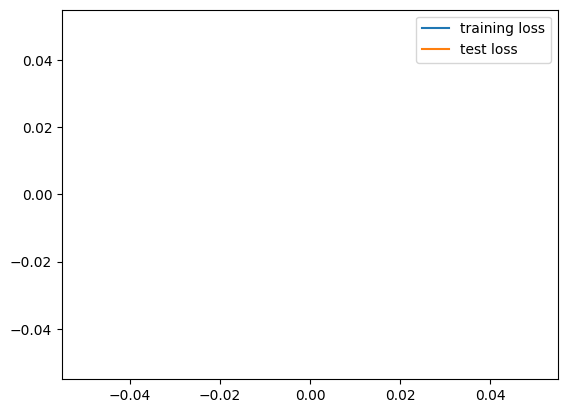

In [70]:
# Graph of loss per epoch
plt.plot(list_loss_per_epoch_train, label ='training loss')
plt.plot(list_loss_per_epoch_test, label = 'test loss')
plt.legend()

In [ ]:
plt.plot(list_accuracy_per_epoch_train, label = 'training accuracy')
plt.plot(list_accuracy_per_epoch_test, label = 'test accuracy')
plt.legend()

# version with transfer learning and fine-tuning

In [9]:
# class to erase the unneeded layer for fine tuning
class Erase_Layer(nn.Module):
  def __init__(self):
    super(Erase_Layer, self).__init__()
  def forward(self, x):
    return x

for param in model.parameters():
  param.requires_grad = False



model.fc = nn.Sequential(nn.Linear(768, 400),
                         nn.Linear(400, 200),
                         nn.Linear(200, 100),
                         nn.Linear(100, 20),
                         nn.Linear(20, 5))

model.to(device)

ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
 

In [10]:
list_accuracy_per_epoch_train = []
list_loss_per_epoch_train = []

list_accuracy_per_epoch_test = []
list_loss_per_epoch_test = []

number_of_epochs = []



for epoch in tqdm(range(num_epochs)):
  number_of_epochs.append(epoch)
  model.train()
  train_loss, test_loss = 0, 0
  train_corrects, test_corrects = 0, 0
  for inputs, labels in tqdm(train_dataloader, desc = 'train'):
    input, label = inputs.to(device), labels.to(device)
    vision_transformer_output = model(input)
    cost_function = loss_function(vision_transformer_output, label)

    optimizer.zero_grad()

    cost_function.backward()

    optimizer.step()

    with warmup_scheduler.dampening():
      learning_rate_scheduler.step()

    gradient_clipping = torch.nn.utils.clip_grad_norm(model.parameters(), 1)
    
    _, preds = torch.max(vision_transformer_output, 1)

    train_loss = train_loss + cost_function.item()
    train_corrects = train_corrects + torch.sum(preds == label)

  accuracy_per_epoch_train = train_corrects / len(train_dataloader.dataset)
  list_accuracy_per_epoch_train.append(accuracy_per_epoch_train)

  loss_per_epoch_train = train_loss / len(train_dataloader)
  list_loss_per_epoch_train.append(loss_per_epoch_train)

  print("the loss of training results per epoch is {:4f}".format(loss_per_epoch_train))
  print("the accuracy of training results per epoch is {:4f}".format(accuracy_per_epoch_train))

  with torch.no_grad():
    model.eval()
    for inputs, labels in tqdm(test_dataloader, desc='test'):
      test_input, test_label = inputs.to(device), labels.to(device)
      vit_output = model(test_input)
      output_loss = loss_function(vit_output, test_label)

      _, test_preds = torch.max(vit_output, 1)

      test_loss = test_loss + output_loss.item()
      test_corrects = test_corrects + torch.sum(test_preds == test_label)
    accuracy_per_epoch_test = test_corrects / len(test_dataloader.dataset)
    loss_per_epoch_test = test_loss / len(test_dataloader)

    list_accuracy_per_epoch_test.append(accuracy_per_epoch_test)
    list_loss_per_epoch_test.append(loss_per_epoch_test)

    print("the loss of testing results per epoch is {:4f}".format(loss_per_epoch_test))
    print("the accuracy of testing results per epoch is {:4f}".format(accuracy_per_epoch_test))

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\shpar\AppData\Local\Temp\ipykernel_15076\3971879612.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  gradient_clipping = torch.nn.utils.clip_grad_norm(model.parameters(), 1)
train: 100%|██████████| 799/799 [12:50<00:00,  1.04it/s]


the loss of training results per epoch is 1.597618
the accuracy of training results per epoch is 0.166217


  1%|          | 1/100 [16:55<27:56:00, 1015.76s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [12:20<00:00,  1.08it/s]


the loss of training results per epoch is 1.597506
the accuracy of training results per epoch is 0.166373


  2%|▏         | 2/100 [34:57<28:42:18, 1054.47s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [14:22<00:00,  1.08s/it]


the loss of training results per epoch is 1.597547
the accuracy of training results per epoch is 0.166060


  3%|▎         | 3/100 [54:05<29:33:57, 1097.29s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:53<00:00,  1.12it/s]


the loss of training results per epoch is 1.597334
the accuracy of training results per epoch is 0.166412


  4%|▍         | 4/100 [1:10:05<27:48:37, 1042.89s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597353
the accuracy of training results per epoch is 0.168565


  5%|▌         | 5/100 [1:25:38<26:28:35, 1003.32s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:31<00:00,  1.16it/s]


the loss of training results per epoch is 1.597390
the accuracy of training results per epoch is 0.166060


  6%|▌         | 6/100 [1:41:19<25:38:40, 982.13s/it] 

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597341
the accuracy of training results per epoch is 0.166647


  7%|▋         | 7/100 [1:56:51<24:56:48, 965.68s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:15<00:00,  1.18it/s]


the loss of training results per epoch is 1.597360
the accuracy of training results per epoch is 0.166334


  8%|▊         | 8/100 [2:12:08<24:17:16, 950.40s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:10<00:00,  1.19it/s]


the loss of training results per epoch is 1.597409
the accuracy of training results per epoch is 0.167078


  9%|▉         | 9/100 [2:27:19<23:42:36, 937.99s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:13<00:00,  1.19it/s]


the loss of training results per epoch is 1.597221
the accuracy of training results per epoch is 0.166530


 10%|█         | 10/100 [2:42:36<23:17:28, 931.65s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:24<00:00,  1.17it/s]


the loss of training results per epoch is 1.597431
the accuracy of training results per epoch is 0.166491


 11%|█         | 11/100 [2:58:06<23:01:11, 931.14s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597198
the accuracy of training results per epoch is 0.166491


 12%|█▏        | 12/100 [3:13:40<22:46:40, 931.83s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597343
the accuracy of training results per epoch is 0.167391


 13%|█▎        | 13/100 [3:29:13<22:31:44, 932.24s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:26<00:00,  1.16it/s]


the loss of training results per epoch is 1.597368
the accuracy of training results per epoch is 0.165356


 14%|█▍        | 14/100 [3:44:47<22:16:47, 932.65s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597138
the accuracy of training results per epoch is 0.169074


 15%|█▌        | 15/100 [4:00:20<22:01:45, 933.00s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:26<00:00,  1.16it/s]


the loss of training results per epoch is 1.597308
the accuracy of training results per epoch is 0.165160


 16%|█▌        | 16/100 [4:15:53<21:45:52, 932.76s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:25<00:00,  1.16it/s]


the loss of training results per epoch is 1.597515
the accuracy of training results per epoch is 0.168173


 17%|█▋        | 17/100 [4:31:24<21:29:50, 932.41s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:25<00:00,  1.17it/s]


the loss of training results per epoch is 1.597524
the accuracy of training results per epoch is 0.166451


 18%|█▊        | 18/100 [4:46:56<21:14:15, 932.38s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597427
the accuracy of training results per epoch is 0.167900


 19%|█▉        | 19/100 [5:02:30<20:59:04, 932.65s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597360
the accuracy of training results per epoch is 0.167626


 20%|██        | 20/100 [5:18:03<20:43:36, 932.70s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:26<00:00,  1.16it/s]


the loss of training results per epoch is 1.597478
the accuracy of training results per epoch is 0.167078


 21%|██        | 21/100 [5:33:34<20:27:34, 932.34s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:25<00:00,  1.17it/s]


the loss of training results per epoch is 1.597516
the accuracy of training results per epoch is 0.165316


 22%|██▏       | 22/100 [5:49:06<20:12:01, 932.33s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597224
the accuracy of training results per epoch is 0.169191


 23%|██▎       | 23/100 [6:04:40<19:56:49, 932.60s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:29<00:00,  1.16it/s]


the loss of training results per epoch is 1.597522
the accuracy of training results per epoch is 0.165786


 24%|██▍       | 24/100 [6:20:15<19:42:10, 933.30s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:25<00:00,  1.17it/s]


the loss of training results per epoch is 1.597376
the accuracy of training results per epoch is 0.166334


 25%|██▌       | 25/100 [6:35:45<19:25:25, 932.34s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [12:15<00:00,  1.09it/s]


the loss of training results per epoch is 1.597639
the accuracy of training results per epoch is 0.167352


 26%|██▌       | 26/100 [6:52:48<19:43:42, 959.77s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [12:51<00:00,  1.04it/s]


the loss of training results per epoch is 1.597473
the accuracy of training results per epoch is 0.167430


 27%|██▋       | 27/100 [7:10:24<20:02:49, 988.63s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:37<00:00,  1.14it/s]


the loss of training results per epoch is 1.597150
the accuracy of training results per epoch is 0.168565


 28%|██▊       | 28/100 [7:26:02<19:28:10, 973.48s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:12<00:00,  1.19it/s]


the loss of training results per epoch is 1.597467
the accuracy of training results per epoch is 0.164338


 29%|██▉       | 29/100 [7:41:15<18:50:09, 955.07s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597346
the accuracy of training results per epoch is 0.167900


 30%|███       | 30/100 [7:56:28<18:19:40, 942.58s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597333
the accuracy of training results per epoch is 0.166999


 31%|███       | 31/100 [8:11:40<17:53:17, 933.30s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:12<00:00,  1.19it/s]


the loss of training results per epoch is 1.597553
the accuracy of training results per epoch is 0.165160


 32%|███▏      | 32/100 [8:26:54<17:31:24, 927.71s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [13:20<00:00,  1.00s/it]


the loss of training results per epoch is 1.597431
the accuracy of training results per epoch is 0.167312


 33%|███▎      | 33/100 [8:45:01<18:09:16, 975.46s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [13:20<00:00,  1.00s/it]


the loss of training results per epoch is 1.597560
the accuracy of training results per epoch is 0.165982


 34%|███▍      | 34/100 [9:03:09<18:29:56, 1009.04s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [13:21<00:00,  1.00s/it]


the loss of training results per epoch is 1.597078
the accuracy of training results per epoch is 0.170287


 35%|███▌      | 35/100 [9:21:16<18:38:36, 1032.57s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [13:20<00:00,  1.00s/it]


the loss of training results per epoch is 1.597429
the accuracy of training results per epoch is 0.166334


 36%|███▌      | 36/100 [9:39:19<18:37:31, 1047.68s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [12:37<00:00,  1.05it/s]


the loss of training results per epoch is 1.597268
the accuracy of training results per epoch is 0.169543


 37%|███▋      | 37/100 [9:56:03<18:06:11, 1034.48s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:29<00:00,  1.16it/s]


the loss of training results per epoch is 1.597371
the accuracy of training results per epoch is 0.166256


 38%|███▊      | 38/100 [10:11:40<17:18:51, 1005.35s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597329
the accuracy of training results per epoch is 0.166608


 39%|███▉      | 39/100 [10:27:13<16:39:52, 983.49s/it] 

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597272
the accuracy of training results per epoch is 0.167626


 40%|████      | 40/100 [10:42:47<16:08:44, 968.75s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597282
the accuracy of training results per epoch is 0.165864


 41%|████      | 41/100 [10:58:21<15:42:28, 958.45s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597591
the accuracy of training results per epoch is 0.167273


 42%|████▏     | 42/100 [11:13:57<15:19:48, 951.52s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [13:54<00:00,  1.05s/it]


the loss of training results per epoch is 1.597371
the accuracy of training results per epoch is 0.164808


 43%|████▎     | 43/100 [11:32:55<15:57:15, 1007.65s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:36<00:00,  1.15it/s]


the loss of training results per epoch is 1.597558
the accuracy of training results per epoch is 0.166451


 44%|████▍     | 44/100 [11:48:38<15:22:10, 988.05s/it] 

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597288
the accuracy of training results per epoch is 0.165082


 45%|████▌     | 45/100 [12:04:12<14:50:55, 971.92s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597472
the accuracy of training results per epoch is 0.165551


 46%|████▌     | 46/100 [12:19:47<14:24:46, 960.87s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597436
the accuracy of training results per epoch is 0.167547


 47%|████▋     | 47/100 [12:35:20<14:01:29, 952.62s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597518
the accuracy of training results per epoch is 0.165042


 48%|████▊     | 48/100 [12:50:54<13:40:42, 946.96s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597443
the accuracy of training results per epoch is 0.164925


 49%|████▉     | 49/100 [13:06:28<13:21:40, 943.15s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597192
the accuracy of training results per epoch is 0.168173


 50%|█████     | 50/100 [13:22:04<13:04:02, 940.86s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597294
the accuracy of training results per epoch is 0.166256


 51%|█████     | 51/100 [13:37:38<12:46:36, 938.70s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597153
the accuracy of training results per epoch is 0.166491


 52%|█████▏    | 52/100 [13:53:12<12:29:49, 937.28s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597530
the accuracy of training results per epoch is 0.165356


 53%|█████▎    | 53/100 [14:08:46<12:13:32, 936.43s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597483
the accuracy of training results per epoch is 0.166373


 54%|█████▍    | 54/100 [14:24:22<11:57:46, 936.23s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597428
the accuracy of training results per epoch is 0.166491


 55%|█████▌    | 55/100 [14:39:56<11:41:42, 935.62s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597516
the accuracy of training results per epoch is 0.167743


 56%|█████▌    | 56/100 [14:55:30<11:25:45, 935.11s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597455
the accuracy of training results per epoch is 0.166491


 57%|█████▋    | 57/100 [15:11:04<11:09:56, 934.81s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597472
the accuracy of training results per epoch is 0.167038


 58%|█████▊    | 58/100 [15:26:40<10:54:33, 935.08s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597468
the accuracy of training results per epoch is 0.165551


 59%|█████▉    | 59/100 [15:42:14<10:38:47, 934.82s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597437
the accuracy of training results per epoch is 0.167626


 60%|██████    | 60/100 [15:57:48<10:23:04, 934.62s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597122
the accuracy of training results per epoch is 0.168800


 61%|██████    | 61/100 [16:13:22<10:07:23, 934.45s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597143
the accuracy of training results per epoch is 0.169661


 62%|██████▏   | 62/100 [16:28:57<9:51:59, 934.73s/it] 

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597488
the accuracy of training results per epoch is 0.166256


 63%|██████▎   | 63/100 [16:44:31<9:36:16, 934.51s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597226
the accuracy of training results per epoch is 0.170483


 64%|██████▍   | 64/100 [17:00:06<9:20:38, 934.39s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597445
the accuracy of training results per epoch is 0.166295


 65%|██████▌   | 65/100 [17:15:39<9:04:55, 934.15s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597243
the accuracy of training results per epoch is 0.167860


 66%|██████▌   | 66/100 [17:31:15<8:49:34, 934.54s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:27<00:00,  1.16it/s]


the loss of training results per epoch is 1.597174
the accuracy of training results per epoch is 0.167234


 67%|██████▋   | 67/100 [17:46:48<8:33:51, 934.30s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597215
the accuracy of training results per epoch is 0.166451


 68%|██████▊   | 68/100 [18:02:23<8:18:16, 934.28s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597188
the accuracy of training results per epoch is 0.167078


 69%|██████▉   | 69/100 [18:17:56<8:02:38, 934.16s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597030
the accuracy of training results per epoch is 0.170248


 70%|███████   | 70/100 [18:33:32<7:47:15, 934.53s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597564
the accuracy of training results per epoch is 0.167234


 71%|███████   | 71/100 [18:49:06<7:31:36, 934.36s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597360
the accuracy of training results per epoch is 0.167273


 72%|███████▏  | 72/100 [19:04:40<7:15:59, 934.26s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597478
the accuracy of training results per epoch is 0.167195


 73%|███████▎  | 73/100 [19:20:14<7:00:23, 934.21s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597510
the accuracy of training results per epoch is 0.167234


 74%|███████▍  | 74/100 [19:35:50<6:45:02, 934.70s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597493
the accuracy of training results per epoch is 0.165747


 75%|███████▌  | 75/100 [19:51:25<6:29:28, 934.75s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597108
the accuracy of training results per epoch is 0.168173


 76%|███████▌  | 76/100 [20:06:59<6:13:52, 934.68s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597369
the accuracy of training results per epoch is 0.166217


 77%|███████▋  | 77/100 [20:22:34<5:58:16, 934.63s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597451
the accuracy of training results per epoch is 0.165864


 78%|███████▊  | 78/100 [20:38:10<5:42:50, 935.02s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:28<00:00,  1.16it/s]


the loss of training results per epoch is 1.597453
the accuracy of training results per epoch is 0.167508


 79%|███████▉  | 79/100 [20:53:44<5:27:11, 934.82s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:31<00:00,  1.16it/s]


the loss of training results per epoch is 1.597469
the accuracy of training results per epoch is 0.163477


 80%|████████  | 80/100 [21:09:23<5:12:02, 936.14s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:35<00:00,  1.15it/s]


the loss of training results per epoch is 1.597347
the accuracy of training results per epoch is 0.165238


 81%|████████  | 81/100 [21:25:05<4:57:01, 937.98s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597384
the accuracy of training results per epoch is 0.166491


 82%|████████▏ | 82/100 [21:40:44<4:41:26, 938.14s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [13:40<00:00,  1.03s/it]


the loss of training results per epoch is 1.597501
the accuracy of training results per epoch is 0.164416


 83%|████████▎ | 83/100 [21:59:20<4:40:54, 991.43s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [12:42<00:00,  1.05it/s]


the loss of training results per epoch is 1.597296
the accuracy of training results per epoch is 0.168878


 84%|████████▍ | 84/100 [22:16:03<4:25:18, 994.90s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:12<00:00,  1.19it/s]


the loss of training results per epoch is 1.597724
the accuracy of training results per epoch is 0.165277


 85%|████████▌ | 85/100 [22:31:15<4:02:31, 970.11s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597175
the accuracy of training results per epoch is 0.167782


 86%|████████▌ | 86/100 [22:46:29<3:42:24, 953.15s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:15<00:00,  1.18it/s]


the loss of training results per epoch is 1.597435
the accuracy of training results per epoch is 0.168526


 87%|████████▋ | 87/100 [23:01:45<3:24:06, 942.00s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597518
the accuracy of training results per epoch is 0.165630


 88%|████████▊ | 88/100 [23:17:00<3:06:46, 933.89s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:18<00:00,  1.18it/s]


the loss of training results per epoch is 1.597248
the accuracy of training results per epoch is 0.164534


 89%|████████▉ | 89/100 [23:32:19<2:50:25, 929.58s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597248
the accuracy of training results per epoch is 0.167547


 90%|█████████ | 90/100 [23:47:32<2:34:06, 924.61s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597624
the accuracy of training results per epoch is 0.166491


 91%|█████████ | 91/100 [24:02:43<2:18:05, 920.61s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:12<00:00,  1.19it/s]


the loss of training results per epoch is 1.597293
the accuracy of training results per epoch is 0.167860


 92%|█████████▏| 92/100 [24:17:56<2:02:24, 918.08s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597428
the accuracy of training results per epoch is 0.167117


 93%|█████████▎| 93/100 [24:33:07<1:46:53, 916.24s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:12<00:00,  1.19it/s]


the loss of training results per epoch is 1.597476
the accuracy of training results per epoch is 0.166530


 94%|█████████▍| 94/100 [24:48:45<1:32:15, 922.62s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:13<00:00,  1.19it/s]


the loss of training results per epoch is 1.597517
the accuracy of training results per epoch is 0.165042


 95%|█████████▌| 95/100 [25:03:59<1:16:39, 919.95s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597565
the accuracy of training results per epoch is 0.163125


 96%|█████████▌| 96/100 [25:19:10<1:01:09, 917.49s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597546
the accuracy of training results per epoch is 0.163399


 97%|█████████▋| 97/100 [25:34:23<45:47, 915.92s/it]  

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:12<00:00,  1.19it/s]


the loss of training results per epoch is 1.597567
the accuracy of training results per epoch is 0.164808


 98%|█████████▊| 98/100 [25:49:36<30:30, 915.24s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:11<00:00,  1.19it/s]


the loss of training results per epoch is 1.597368
the accuracy of training results per epoch is 0.166295


 99%|█████████▉| 99/100 [26:04:48<15:14, 914.08s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


train: 100%|██████████| 799/799 [11:12<00:00,  1.19it/s]


the loss of training results per epoch is 1.597284
the accuracy of training results per epoch is 0.165434


100%|██████████| 100/100 [26:20:00<00:00, 948.01s/it]

the loss of testing results per epoch is 1.591974
the accuracy of testing results per epoch is 0.174536


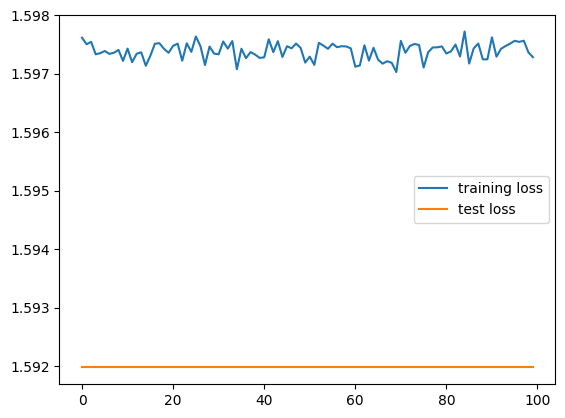

In [11]:
# Graph of loss per epoch
plt.plot(list_loss_per_epoch_train, label ='training loss')
plt.plot(list_loss_per_epoch_test, label = 'test loss')
plt.legend()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

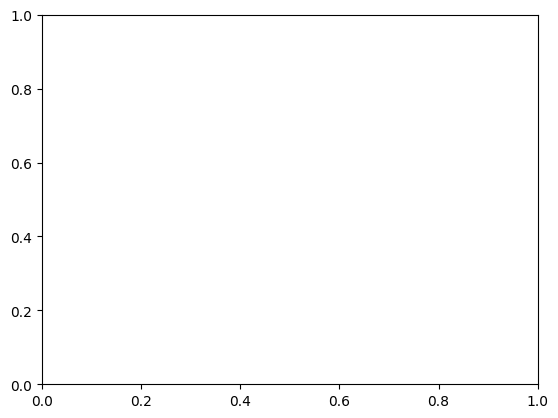

In [12]:
plt.plot(list_accuracy_per_epoch_train, label = 'training accuracy')
plt.plot(list_accuracy_per_epoch_test, label = 'test accuracy')
plt.legend()